In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tabulate import tabulate

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, classification_report, confusion_matrix, f1_score, recall_score
from xgboost import XGBClassifier

# Test 2: Without Enrolled and Approved

## Import file

In [2]:
User = "Kai Jie\Jupyter_DS\Assignment\Final"
file_name = "filtered_test_2"
file_path = rf"C:\Users\{User}\{file_name}.csv"
df = pd.read_csv(file_path)

In [3]:
df.shape

(2274, 24)

In [4]:
df['Target'].unique()

array([1, 0, 2], dtype=int64)

In [7]:
drop_list = [2]
df = df[~df['Target'].isin(drop_list)]

In [8]:
df['Target'].unique()

array([1, 0], dtype=int64)

## Data sampling

In [9]:
percentage_to_extract = 0.05

# Separate data based on target values
df_target_0 = df[df['Target'] == 0]
df_target_1 = df[df['Target'] == 1]

# Calculate the number of samples to extract for each target value
num_samples_each_target = int(len(df) * percentage_to_extract / 2)

# Randomly sample data for each target value
sampled_data_target_0 = df_target_0.sample(n=num_samples_each_target)
sampled_data_target_1 = df_target_1.sample(n=num_samples_each_target)

df_unseen = pd.concat([sampled_data_target_0, sampled_data_target_1])

# Remove the unseen data from the original dataframe to get the training data
df = df.drop(df_unseen.index)

# Shuffle the new dataframes
df_unseen = df_unseen.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

X_unseen = df_unseen.drop('Target', axis=1)
Y_unseen_true = df_unseen['Target']

In [10]:
df.shape

(1722, 24)

## Train, test, validation(unseen)

In [11]:
target = df['Target']
features = df.drop(columns=['Target'])

X_train, X_temp, Y_train, Y_temp = train_test_split(features,target, test_size=0.4, random_state=123, shuffle=True)

#X_temp & Y_temp bring into here to split into test and validation
X_val, X_test, Y_val, Y_test = train_test_split(X_temp,Y_temp, test_size=0.2, random_state=123, shuffle=True)

# Print class distribution before resampling
print("Class distribution before resampling:")
print("Y_train distribution:\n", Y_train.value_counts())
print("Y_temp distribution:\n", Y_temp.value_counts())

# Print class distribution of validation and test sets
print("\nClass distribution of validation and test sets:")
print("Y_val distribution:\n", Y_val.value_counts())
print("Y_test distribution:\n", Y_test.value_counts())

Class distribution before resampling:
Y_train distribution:
 Target
1    846
0    187
Name: count, dtype: int64
Y_temp distribution:
 Target
1    586
0    103
Name: count, dtype: int64

Class distribution of validation and test sets:
Y_val distribution:
 Target
1    461
0     90
Name: count, dtype: int64
Y_test distribution:
 Target
1    125
0     13
Name: count, dtype: int64


## Data Resampling

In [12]:
# Check the class distribution before resampling
print("Class Distribution Before Resampling:")
print(Counter(Y_train))

Class Distribution Before Resampling:
Counter({1: 846, 0: 187})


In [13]:
smote = SMOTE(random_state=123)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Check the class distribution after resampling
print("Class Distribution After Resampling:")
print(Counter(Y_train_resampled))

Class Distribution After Resampling:
Counter({1: 846, 0: 846})


## StandardScaler

In [14]:
sc = StandardScaler()

# Fit the scaler on training data and transform training data
X_train_resampled = sc.fit_transform(X_train_resampled)

# Transform test and validation data using the same scaler
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

print("\nTraining Set Shape:", X_train_resampled.shape, Y_train_resampled.shape)
print("Test Set Shape:", X_test.shape, Y_test.shape)
print("Unseen Data Shape:", X_val.shape, Y_val.shape)


Training Set Shape: (1692, 23) (1692,)
Test Set Shape: (138, 23) (138,)
Unseen Data Shape: (551, 23) (551,)


## Functions

In [15]:
def evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val):
    model = insert_model
    model.fit(X_train_resampled, Y_train_resampled)
    predictions = model.predict(X_val)

    # Calculate and print evaluation metrics
    accuracy = round(accuracy_score(Y_val, predictions), 4)
    precision = round(precision_score(Y_val, predictions, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    recall = round(recall_score(Y_val, predictions, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    f1 = round(f1_score(Y_val, predictions, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    error_rate = round(1 - accuracy, 4)

    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Support': f1,
        'Error Rate': error_rate
    }
    return results
    


def evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test):
    model = insert_model
    model.fit(X_train_resampled, Y_train_resampled)
    Y_test_pred = model.predict(X_test)

    # Calculate and print evaluation metrics
    accuracy = round(accuracy_score(Y_test, Y_test_pred), 4)
    precision = round(precision_score(Y_test, Y_test_pred, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    recall = round(recall_score(Y_test, Y_test_pred, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    f1 = round(f1_score(Y_test, Y_test_pred, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    error_rate = round(1 - accuracy, 4)
    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Support': f1,
        'Error Rate': error_rate
    }
    return results


def evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled):
    model = insert_model
    model.fit(X_train_resampled, Y_train_resampled)
    Y_train_pred = model.predict(X_train_resampled)

    # Calculate and print evaluation metrics
    train_acc = round(accuracy_score(Y_train_resampled, Y_train_pred), 4)
    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Accuracy': train_acc
    }
    return results



def default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test):
    model_default = insert_model
    
    # Fit the model on the training data
    model_default.fit(X_train_resampled, Y_train_resampled)
    
    # Predict on training data
    Y_train_pred_default = model_default.predict(X_train_resampled)
    
    # Predict on validation set
    Y_val_pred_default = model_default.predict(X_val)
    
    # Predict on test set
    Y_test_pred_default = model_default.predict(X_test)
    
    # Calculate and print accuracy for the default model
    train_accuracy_default = round(accuracy_score(Y_train_resampled, Y_train_pred_default), 4)
    test_accuracy_default = round(accuracy_score(Y_test, Y_test_pred_default), 4)
    val_accuracy_default = round(accuracy_score(Y_val, Y_val_pred_default), 4)

    # Calculate error rate
    train_accuracy_error_rate = round(1 - train_accuracy_default , 4)
    test_accuracy_error_rate = round(1 - test_accuracy_default , 4)
    val_accuracy_error_rate = round(1 - val_accuracy_default , 4)

    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Train Accuracy': train_accuracy_default,
        'Test Accuracy': test_accuracy_default,
        'Valid Accuracy': val_accuracy_default,
        'Train ACC Error': train_accuracy_error_rate,
        'Test ACC Error': test_accuracy_error_rate,
        'Valid ACC Error': val_accuracy_error_rate,
    }
    return results



def default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test):
    model_default = insert_model
    
    # Fit the model on the training data
    model_default.fit(X_train_resampled, Y_train_resampled)
    
    # Predict on training data
    Y_train_pred_default = model_default.predict(X_train_resampled)
    
    # Predict on validation set
    Y_val_pred_default = model_default.predict(X_val)
    
    # Predict on test set
    Y_test_pred_default = model_default.predict(X_test)

    # Calculate classification reports
    train_classification_report = classification_report(Y_train_resampled, Y_train_pred_default, output_dict=True)
    test_classification_report = classification_report(Y_test, Y_test_pred_default, output_dict=True)
    val_classification_report = classification_report(Y_val, Y_val_pred_default, output_dict=True)

    # Calculate confusion matrices
    train_confusion_matrix = confusion_matrix(Y_train_resampled, Y_train_pred_default)
    test_confusion_matrix = confusion_matrix(Y_test, Y_test_pred_default)
    val_confusion_matrix = confusion_matrix(Y_val, Y_val_pred_default)

    # Display classification report
    print(f"Classification Report for Training Data:\n{classification_report(Y_train_resampled, Y_train_pred_default)}")
    print(f"Classification Report for Test Data:\n{classification_report(Y_test, Y_test_pred_default)}")
    print(f"Classification Report for Validation Data:\n{classification_report(Y_val, Y_val_pred_default)}")

    # Display confusion matrix
    def plot_confusion_matrix(cm, title='Confusion Matrix'):
        plt.figure(figsize=(3,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_default.classes_, yticklabels=model_default.classes_)
        plt.title(title)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    print("Confusion Matrix for Training Data:")
    plot_confusion_matrix(train_confusion_matrix, title='Confusion Matrix for Training Data')

    print("Confusion Matrix for Test Data:")
    plot_confusion_matrix(test_confusion_matrix, title='Confusion Matrix for Test Data')
    
    print("Confusion Matrix for Validation Data:")
    plot_confusion_matrix(val_confusion_matrix, title='Confusion Matrix for Validation Data')



def cross_validate_default_model(model, model_name, cv, X_train_resampled, Y_train_resampled):
    cross_val_scores = cross_val_score(model, X_train_resampled, Y_train_resampled, cv=cv, scoring='accuracy')
    mean_cv_score = round(np.mean(cross_val_scores), 4)
    std_cv_score = round(np.std(cross_val_scores), 4)
    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'CV score': ', '.join([f'{score:.4f}' for score in cross_val_scores]),
        'Mean CV': mean_cv_score,
        'Std CV': std_cv_score,
    }
    return results

In [16]:
valid_list = []
test_list = []
train_list = []
acc_train_test_valid_list = []
hyper_list = []

def showTablulate(txt, results_list, number):
    if number == 0:
        headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Support', 'Error Rate']
    elif number == 1:
        headers = ['Model', 'Accuracy']
    elif number == 2:
        headers = ['Model', 'Train Accuracy', 'Test Accuracy', 'Valid Accuracy', 'Train ACC Error', 'Test ACC Error', 'Valid ACC Error']
    elif number == 3:
        headers = ['Model', 'Best HP.', 'Train Accuracy', 'Test Accuracy', 'Valid Accuracy', 'Precision Unseen %', 'Accuracy Unseen %']
    elif number == 4:
        headers = ['Model', 'CV score', 'Mean CV', 'Std CV']

    # Convert list of dictionaries to list of lists
    table_data = []
    for result in results_list:
        row = [result.get(header, 'N/A') for header in headers]  # Use 'N/A' for missing data
        table_data.append(row)

    # Use tabulate to format the results into a table
    table = tabulate(table_data, headers=headers, tablefmt='grid')

    # Print the table
    print(f"{txt}")
    print(table)
    print("\n")

In [17]:
def hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average):
    model_grid_search = insert_model_hyperparameter

    # Fit GridSearchCV on the training data
    model_grid_search.fit(X_train_resampled, Y_train_resampled)

    # Predict on training data using the best model from Grid Search
    Y_train_pred_grid = model_grid_search.predict(X_train_resampled)
    
    # Extract the best hyperparameters
    best_params = model_grid_search.best_params_
    best_model = model_grid_search.best_estimator_
    best_score = round(model_grid_search.best_score_ , 4)
    print(f'Best Hyperparameters for {model_name}: {best_params}')
    print(f'Best cross-validation for {model_name}: {best_score}')
    
    # Predict using the best model
    Y_val_pred_grid = best_model.predict(X_val)
    Y_test_pred_grid = best_model.predict(X_test)

    # Calculate and print accuracy for the Grid Search model
    train_accuracy_grid = round(accuracy_score(Y_train_resampled, Y_train_pred_grid), 4)
    test_accuracy_grid = round(accuracy_score(Y_test, Y_test_pred_grid), 4)
    val_accuracy_grid = round(accuracy_score(Y_val, Y_val_pred_grid), 4)

    print(f'Train Accuracy: {train_accuracy_grid}')
    print(f'Test Accuracy: {test_accuracy_grid}')
    print(f'Valid Accuracy: {val_accuracy_grid}')

    Y_unseen_pred = model_grid_search.predict(X_unseen)

    # Evaluate the model on the unseen data
    precision_unseen = precision_score(Y_unseen_true, Y_unseen_pred, average=average, zero_division=1) * 100   # Use appropriate average method for binary/multi-class
    accuracy_unseen = accuracy_score(Y_unseen_true, Y_unseen_pred) * 100
    
    # Format the results as percentages with 2 decimal places
    precision_unseen_formatted = round(precision_unseen, 2)
    accuracy_unseen_formatted = round(accuracy_unseen, 2)

    print(f'Precision Unseen %: {precision_unseen_formatted}')
    print(f'Accuracy Unseen %: {accuracy_unseen_formatted}')

    # Display relevant columns from DataFrame
    cv_results = pd.DataFrame(model_grid_search.cv_results_)
    
    # Identify parameter columns dynamically
    param_columns = [col for col in cv_results.columns if col.startswith('param_')]
    sorted_cv_results = cv_results.sort_values(by='rank_test_score')
    
    print(f"\n{sorted_cv_results[['rank_test_score', 'mean_test_score', 'std_test_score'] + param_columns]}")

    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Best HP.': '\n'.join([f'{param}: {value}' for param, value in best_params.items()]),
        'Best CV score.': best_score,
        'Train Accuracy': train_accuracy_grid,
        'Test Accuracy': test_accuracy_grid,
        'Valid Accuracy': val_accuracy_grid,
        'Precision Unseen %': precision_unseen_formatted,
        'Accuracy Unseen %': accuracy_unseen_formatted,
    }
    return results

# Models

## SVM

### Default SVM

In [18]:
insert_model = SVC(random_state=123)
model_name = "SVM"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'SVM',
 'Train Accuracy': 0.9113,
 'Test Accuracy': 0.8768,
 'Valid Accuracy': 0.8276,
 'Train ACC Error': 0.0887,
 'Test ACC Error': 0.1232,
 'Valid ACC Error': 0.1724}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       846
           1       0.89      0.94      0.91       846

    accuracy                           0.91      1692
   macro avg       0.91      0.91      0.91      1692
weighted avg       0.91      0.91      0.91      1692

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.33      0.31      0.32        13
           1       0.93      0.94      0.93       125

    accuracy                           0.88       138
   macro avg       0.63      0.62      0.63       138
weighted avg       0.87      0.88      0.87       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.47      0.51      0.49        90
           1       0.90      0.89      0.90       461

    accuracy                           0.83       551
   macr

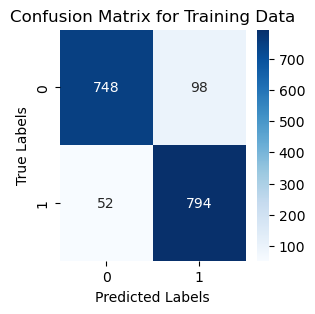

Confusion Matrix for Test Data:


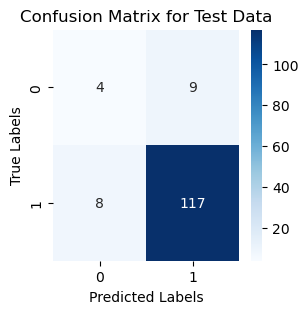

Confusion Matrix for Validation Data:


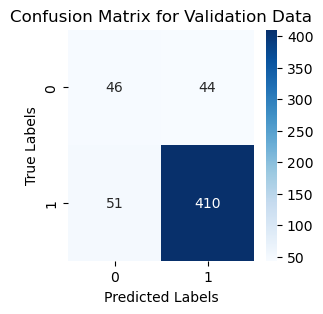

In [19]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid SVM

In [20]:
model = SVC(random_state=123)

param_grid_svm = {
    'C' : [0.1, 1, 10,100],
    'kernel' : ['linear','rbf','poly','sigmoid'],
    'degree' : [2,3,4], # Relevant only for 'poly' kernel
    'gamma' : ['scale','auto'],
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_svm,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "macro"
model_name = "Param_grid_SVM"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 96 candidates, totalling 384 fits
Best Hyperparameters for Param_grid_SVM: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation for Param_grid_SVM: 0.8676
Train Accuracy: 0.9823
Test Accuracy: 0.8696
Valid Accuracy: 0.8221
Precision Unseen %: 75.0
Accuracy Unseen %: 50.0

    rank_test_score  mean_test_score  std_test_score param_C param_degree  \
49                1         0.867612        0.069870      10            2   
57                1         0.867612        0.069870      10            3   
65                1         0.867612        0.069870      10            4   
69                4         0.867021        0.071008      10            4   
61                4         0.867021        0.071008      10            3   
..              ...              ...             ...     ...          ...   
83               92         0.699173        0.031469     100            3   
91               92         0.699173        0.031469    

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


## Decision Tree (DT)

### Default DT

In [21]:
insert_model = DecisionTreeClassifier(random_state=123)
model_name = "DT"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'DT',
 'Train Accuracy': 1.0,
 'Test Accuracy': 0.8478,
 'Valid Accuracy': 0.7895,
 'Train ACC Error': 0.0,
 'Test ACC Error': 0.1522,
 'Valid ACC Error': 0.2105}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       846
           1       1.00      1.00      1.00       846

    accuracy                           1.00      1692
   macro avg       1.00      1.00      1.00      1692
weighted avg       1.00      1.00      1.00      1692

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.25      0.31      0.28        13
           1       0.93      0.90      0.91       125

    accuracy                           0.85       138
   macro avg       0.59      0.61      0.60       138
weighted avg       0.86      0.85      0.85       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.38      0.46      0.41        90
           1       0.89      0.85      0.87       461

    accuracy                           0.79       551
   macr

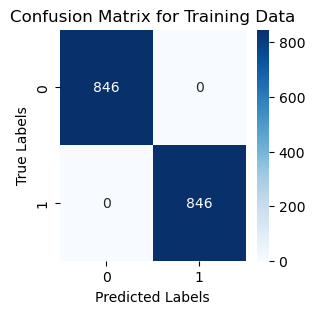

Confusion Matrix for Test Data:


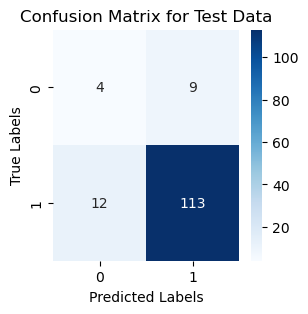

Confusion Matrix for Validation Data:


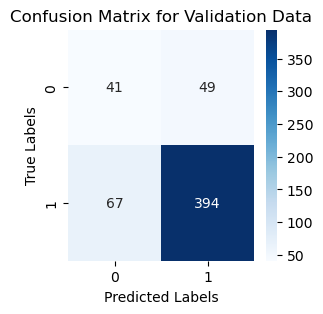

In [22]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid DT

In [23]:
model = DecisionTreeClassifier(random_state=123, 
    max_depth=10, 
    min_samples_split=5, 
    min_samples_leaf=4
)

param_grid_dt = {
    'criterion': ['gini', 'entropy'],             # Quality measure of a split
    'max_depth': [None, 10, 20, 30, 40, 50],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]                   # Minimum samples required at a leaf node
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_dt,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_DT"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best Hyperparameters for Param_grid_DT: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation for Param_grid_DT: 0.8487
Train Accuracy: 0.9846
Test Accuracy: 0.8188
Valid Accuracy: 0.784
Precision Unseen %: 53.01
Accuracy Unseen %: 52.22

     rank_test_score  mean_test_score  std_test_score param_criterion  \
57                 1         0.848700        0.040673         entropy   
102                1         0.848700        0.040673         entropy   
84                 1         0.848700        0.040673         entropy   
75                 1         0.848700        0.040673         entropy   
93                 1         0.848700        0.040673         entropy   
..               ...              ...             ...             ...   
49               102         0.817967        0.042717            gini   
4                102         0.817967        0.042717  

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


## Random Forest (RF)

### Default RF

In [24]:
insert_model = RandomForestClassifier(random_state=123)
model_name = "RF"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'RF',
 'Train Accuracy': 1.0,
 'Test Accuracy': 0.9058,
 'Valid Accuracy': 0.8893,
 'Train ACC Error': 0.0,
 'Test ACC Error': 0.0942,
 'Valid ACC Error': 0.1107}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       846
           1       1.00      1.00      1.00       846

    accuracy                           1.00      1692
   macro avg       1.00      1.00      1.00      1692
weighted avg       1.00      1.00      1.00      1692

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        13
           1       0.94      0.96      0.95       125

    accuracy                           0.91       138
   macro avg       0.72      0.67      0.69       138
weighted avg       0.90      0.91      0.90       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.74      0.50      0.60        90
           1       0.91      0.97      0.94       461

    accuracy                           0.89       551
   macr

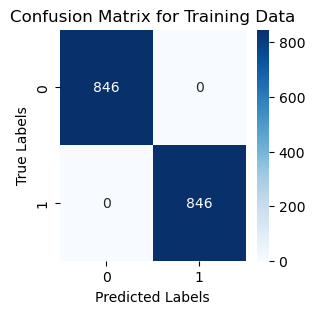

Confusion Matrix for Test Data:


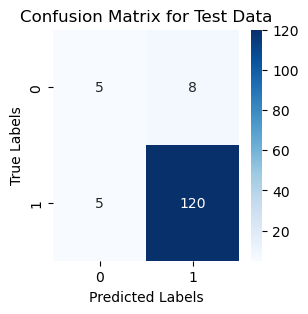

Confusion Matrix for Validation Data:


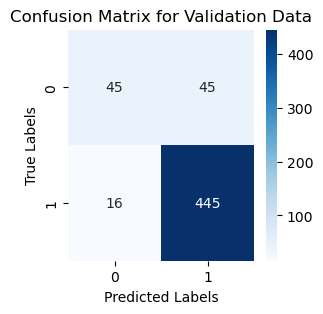

In [25]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid RF

In [26]:
model = RandomForestClassifier(
    random_state=123, 
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=5, 
    min_samples_leaf=4, 
    max_features='sqrt'
)

param_grid_rf = {
    'n_estimators' : [10,50,100,200],
    'criterion' : ['gini','entropy'],
    'max_depth' : [None, 1, 5, 10, 15, 20],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4],
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_rf,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_RF"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
Best Hyperparameters for Param_grid_RF: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation for Param_grid_RF: 0.9125
Train Accuracy: 1.0
Test Accuracy: 0.9058
Valid Accuracy: 0.882
Precision Unseen %: 75.0
Accuracy Unseen %: 50.0

     rank_test_score  mean_test_score  std_test_score param_criterion  \
218                1         0.912530        0.060573         entropy   
399                2         0.911939        0.068034         entropy   
398                2         0.911939        0.064035         entropy   
181                4         0.911939        0.060049            gini   
219                5         0.911348        0.066247         entropy   
..               ...              ...             ...             ...   
52               424         0.764775        0.037844            gini   
56               424         0.764775 

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## Gradient Boosting (GB)

### Default GB

In [27]:
insert_model = GradientBoostingClassifier(random_state=123)
model_name = "GB"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'GB',
 'Train Accuracy': 0.9527,
 'Test Accuracy': 0.8841,
 'Valid Accuracy': 0.8838,
 'Train ACC Error': 0.0473,
 'Test ACC Error': 0.1159,
 'Valid ACC Error': 0.1162}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       846
           1       0.93      0.98      0.95       846

    accuracy                           0.95      1692
   macro avg       0.95      0.95      0.95      1692
weighted avg       0.95      0.95      0.95      1692

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.36      0.31      0.33        13
           1       0.93      0.94      0.94       125

    accuracy                           0.88       138
   macro avg       0.65      0.63      0.63       138
weighted avg       0.88      0.88      0.88       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.70      0.50      0.58        90
           1       0.91      0.96      0.93       461

    accuracy                           0.88       551
   macr

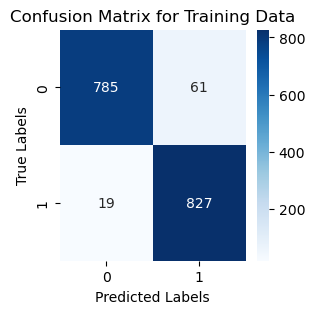

Confusion Matrix for Test Data:


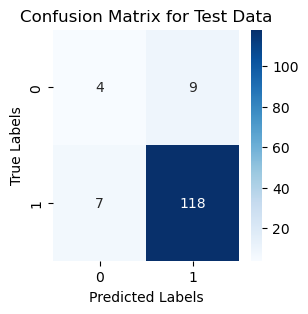

Confusion Matrix for Validation Data:


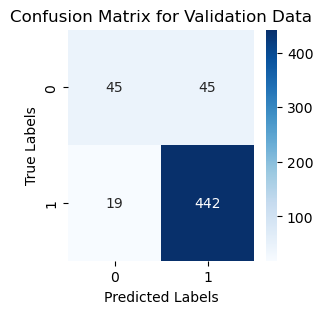

In [28]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid GB

In [29]:
model = GradientBoostingClassifier(
    random_state=123, 
    n_estimators=50, 
    learning_rate=0.1, 
    max_depth=3, 
    subsample=0.8
)

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_gb,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_GB"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best Hyperparameters for Param_grid_GB: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation for Param_grid_GB: 0.9054
Train Accuracy: 0.9817
Test Accuracy: 0.9058
Valid Accuracy: 0.8838
Precision Unseen %: 52.25
Accuracy Unseen %: 51.11

    rank_test_score  mean_test_score  std_test_score param_learning_rate  \
51                1         0.905437        0.091773                 0.1   
59                2         0.900118        0.095392                 0.1   
55                3         0.895981        0.097516                 0.1   
54                3         0.895981        0.092818                 0.1   
50                5         0.895981        0.091484                 0.1   
..              ...              ...             ...                 ...   
5                58         0.787825        0.041164                0.01 

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


## XGBoost (XGB)

### Default XGB

In [30]:
insert_model = XGBClassifier(random_state=123)
model_name = "XGB"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'XGB',
 'Train Accuracy': 1.0,
 'Test Accuracy': 0.9058,
 'Valid Accuracy': 0.8838,
 'Train ACC Error': 0.0,
 'Test ACC Error': 0.0942,
 'Valid ACC Error': 0.1162}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       846
           1       1.00      1.00      1.00       846

    accuracy                           1.00      1692
   macro avg       1.00      1.00      1.00      1692
weighted avg       1.00      1.00      1.00      1692

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.50      0.31      0.38        13
           1       0.93      0.97      0.95       125

    accuracy                           0.91       138
   macro avg       0.72      0.64      0.66       138
weighted avg       0.89      0.91      0.90       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.69      0.53      0.60        90
           1       0.91      0.95      0.93       461

    accuracy                           0.88       551
   macr

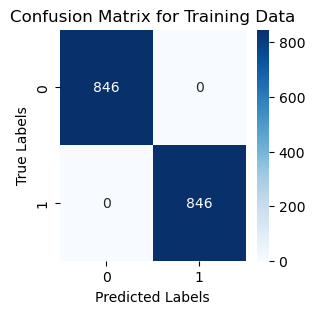

Confusion Matrix for Test Data:


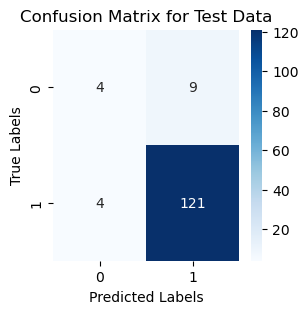

Confusion Matrix for Validation Data:


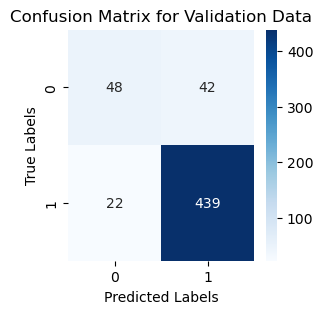

In [31]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid XGB

In [32]:
model = XGBClassifier(random_state=123)

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_xgb,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_XGB"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 243 candidates, totalling 972 fits
Best Hyperparameters for Param_grid_XGB: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation for Param_grid_XGB: 0.9025
Train Accuracy: 0.9994
Test Accuracy: 0.9203
Valid Accuracy: 0.8784
Precision Unseen %: 76.16
Accuracy Unseen %: 54.44

     rank_test_score  mean_test_score  std_test_score param_gamma  \
48                 1         0.902482        0.090011           0   
205                2         0.901891        0.100334         0.2   
133                2         0.901891        0.094998         0.1   
45                 4         0.901300        0.080246           0   
204                4         0.901300        0.097349         0.2   
..               ...              ...             ...         ...   
81               238         0.793144        0.036795         0.1   
162              238         0.793144        0.036795         0.2   
2               

## Naive Bayes (NB)

### Default NB

In [33]:
insert_model = GaussianNB()
model_name = "NB"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'NB',
 'Train Accuracy': 0.8008,
 'Test Accuracy': 0.8478,
 'Valid Accuracy': 0.8475,
 'Train ACC Error': 0.1992,
 'Test ACC Error': 0.1522,
 'Valid ACC Error': 0.1525}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       846
           1       0.76      0.89      0.82       846

    accuracy                           0.80      1692
   macro avg       0.81      0.80      0.80      1692
weighted avg       0.81      0.80      0.80      1692

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.28      0.38      0.32        13
           1       0.93      0.90      0.91       125

    accuracy                           0.85       138
   macro avg       0.61      0.64      0.62       138
weighted avg       0.87      0.85      0.86       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        90
           1       0.92      0.89      0.91       461

    accuracy                           0.85       551
   macr

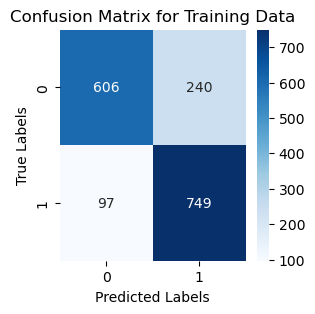

Confusion Matrix for Test Data:


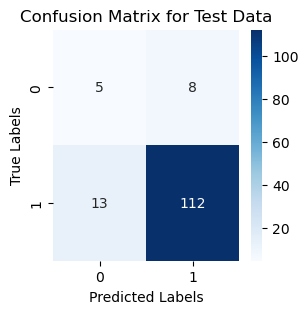

Confusion Matrix for Validation Data:


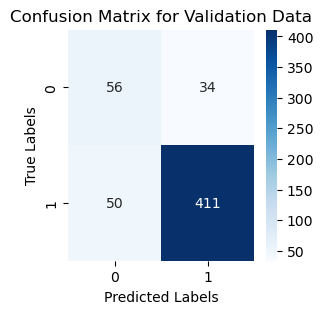

In [34]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid NB

In [35]:
model = GaussianNB(var_smoothing=1e-9)

param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_nb,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_NB"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best Hyperparameters for Param_grid_NB: {'var_smoothing': 1e-07}
Best cross-validation for Param_grid_NB: 0.7565
Train Accuracy: 0.8008
Test Accuracy: 0.8478
Valid Accuracy: 0.8475
Precision Unseen %: 75.0
Accuracy Unseen %: 50.0

   rank_test_score  mean_test_score  std_test_score param_var_smoothing
2                1         0.756501        0.061625                 0.0
0                2         0.755910        0.062600                 0.0
1                2         0.755910        0.062600                 0.0
3                4         0.755319        0.063578            0.000001
4                4         0.755319        0.063578             0.00001


C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


## K-Nearest Neighbors (KNN)

### Default KNN

In [36]:
insert_model = KNeighborsClassifier()
model_name = "KNN"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'KNN',
 'Train Accuracy': 0.893,
 'Test Accuracy': 0.7681,
 'Valid Accuracy': 0.7296,
 'Train ACC Error': 0.107,
 'Test ACC Error': 0.2319,
 'Valid ACC Error': 0.2704}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       846
           1       0.95      0.83      0.89       846

    accuracy                           0.89      1692
   macro avg       0.90      0.89      0.89      1692
weighted avg       0.90      0.89      0.89      1692

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.19      0.46      0.27        13
           1       0.93      0.80      0.86       125

    accuracy                           0.77       138
   macro avg       0.56      0.63      0.57       138
weighted avg       0.86      0.77      0.81       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.32      0.58      0.41        90
           1       0.90      0.76      0.82       461

    accuracy                           0.73       551
   macr

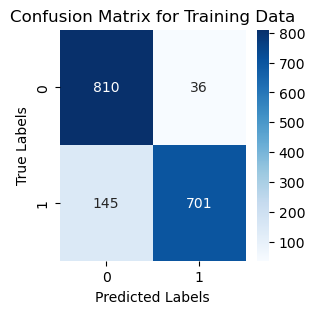

Confusion Matrix for Test Data:


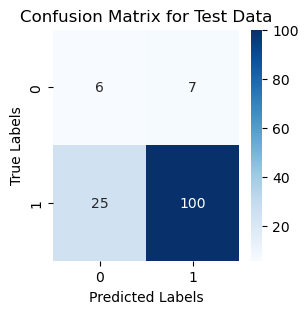

Confusion Matrix for Validation Data:


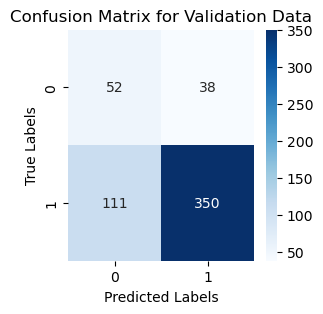

In [37]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid KNN

In [38]:
model = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_knn,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_KNN"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best Hyperparameters for Param_grid_KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best cross-validation for Param_grid_KNN: 0.8918
Train Accuracy: 1.0
Test Accuracy: 0.8333
Valid Accuracy: 0.8076
Precision Unseen %: 75.0
Accuracy Unseen %: 50.0

    rank_test_score  mean_test_score  std_test_score param_n_neighbors  \
5                 1         0.891844        0.022011                 5   
13                2         0.888889        0.030043                10   
1                 3         0.888889        0.016121                 3   
9                 4         0.887116        0.024014                 7   
0                 5         0.883570        0.018111                 3   
4                 6         0.878842        0.029450                 5   
8                 7         0.870567        0.025701                 7   
12                8         0.856383        0.028140                10   
3                 

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## Logistic Regression (LR)

### Default LR

In [39]:
insert_model = LogisticRegression(random_state=123)
model_name = "LR"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'LR',
 'Train Accuracy': 0.7855,
 'Test Accuracy': 0.8116,
 'Valid Accuracy': 0.8113,
 'Train ACC Error': 0.2145,
 'Test ACC Error': 0.1884,
 'Valid ACC Error': 0.1887}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       846
           1       0.77      0.82      0.79       846

    accuracy                           0.79      1692
   macro avg       0.79      0.79      0.79      1692
weighted avg       0.79      0.79      0.79      1692

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.24      0.46      0.32        13
           1       0.94      0.85      0.89       125

    accuracy                           0.81       138
   macro avg       0.59      0.65      0.60       138
weighted avg       0.87      0.81      0.84       138

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.45      0.64      0.53        90
           1       0.92      0.84      0.88       461

    accuracy                           0.81       551
   macr

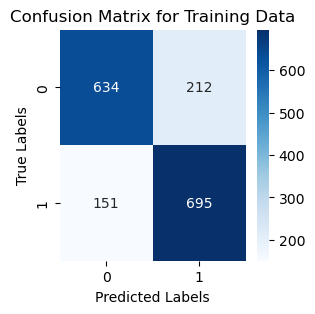

Confusion Matrix for Test Data:


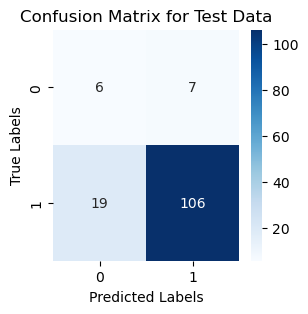

Confusion Matrix for Validation Data:


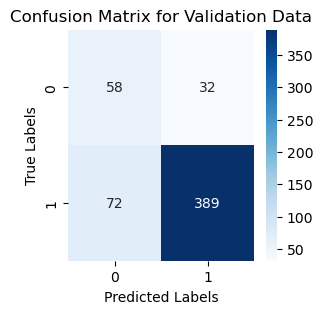

In [40]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid LR

In [41]:
model = LogisticRegression(random_state=123)
    
def get_param_grid_lr(solver):
    if solver == 'liblinear':
        return {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': [solver],
            'penalty': ['l1', 'l2']
        }
    elif solver == 'lbfgs':
        return {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': [solver],
            'penalty': ['l2']
        }
    else:
        raise ValueError("Unsupported solver")

param_grid_lib = get_param_grid_lr('liblinear')

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_lib,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)
average = "weighted"
model_name = "Param_grid_LR(lib)"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Hyperparameters for Param_grid_LR(lib): {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation for Param_grid_LR(lib): 0.7754
Train Accuracy: 0.7884
Test Accuracy: 0.8043
Valid Accuracy: 0.824
Precision Unseen %: 75.0
Accuracy Unseen %: 50.0

   rank_test_score  mean_test_score  std_test_score param_C param_penalty  \
1                1         0.775414        0.034785    0.01            l2   
2                2         0.774232        0.044933     0.1            l1   
3                3         0.773641        0.047381     0.1            l2   
4                4         0.770686        0.051442       1            l1   
6                4         0.770686        0.050344      10            l1   
7                4         0.770686        0.050344      10            l2   
8                4         0.770686        0.050344     100            l1   
9                4         0.770686        0.050344     

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [42]:
param_grid_lbf = get_param_grid_lr('lbfgs')
insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_lbf,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)
model_name = "Param_grid_LR(lbfgs)"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best Hyperparameters for Param_grid_LR(lbfgs): {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation for Param_grid_LR(lbfgs): 0.7766
Train Accuracy: 0.7884
Test Accuracy: 0.8043
Valid Accuracy: 0.8185
Precision Unseen %: 75.0
Accuracy Unseen %: 50.0

   rank_test_score  mean_test_score  std_test_score param_C param_penalty  \
0                1         0.776596        0.035559    0.01            l2   
1                2         0.773050        0.045902     0.1            l2   
3                3         0.770686        0.050344      10            l2   
4                3         0.770686        0.050344     100            l2   
2                5         0.770095        0.051016       1            l2   

  param_solver  
0        lbfgs  
1        lbfgs  
3        lbfgs  
4        lbfgs  
2        lbfgs  


C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Overall comparison between default models

    Accuracy: Overall correctness of the model. Higher is generally better.
    
    Precision: Proportion of true positives among predicted positives. Higher is better, especially if false positives are costly.
    
    F1-Score: Harmonic mean of precision and recall. Balances precision and recall. Higher is better.
    
    Error Rate: Proportion of incorrect predictions. Lower is better.
    
    Cross-Validation Mean Accuracy: Average accuracy across different data subsets. Higher is better.
    
    Cross-Validation Standard Deviation: Variability of accuracy across folds. Lower is better.

In [43]:
# Show results in a table
showTablulate("Valid resutlts of Default Models", valid_list, 0)
showTablulate("Test resutlts of Default Models", test_list, 0)
showTablulate("Train resutlts of Default Models", train_list, 1)
showTablulate("Train, test, validation accuracy resutlts of Default Models", acc_train_test_valid_list, 2)

Valid resutlts of Default Models
+---------+------------+-------------+----------+--------------+--------------+
| Model   |   Accuracy |   Precision |   Recall |   F1-Support |   Error Rate |
+=========+============+=============+==========+==============+==============+
| SVM     |     0.8768 |      0.8725 |   0.8768 |       0.8746 |       0.1232 |
+---------+------------+-------------+----------+--------------+--------------+
| DT      |     0.8478 |      0.8625 |   0.8478 |       0.8548 |       0.1522 |
+---------+------------+-------------+----------+--------------+--------------+
| RF      |     0.9058 |      0.8963 |   0.9058 |       0.9002 |       0.0942 |
+---------+------------+-------------+----------+--------------+--------------+
| GB      |     0.8841 |      0.8759 |   0.8841 |       0.8797 |       0.1159 |
+---------+------------+-------------+----------+--------------+--------------+
| XGB     |     0.9058 |      0.8902 |   0.9058 |       0.8955 |       0.0942 |
+------

### Cross-Validation between default models

In [44]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
cv_list = []

SVM_default = SVC(random_state=123)
DT_default = DecisionTreeClassifier(random_state=123)
RF_default = RandomForestClassifier(random_state=123)
GB_default = GradientBoostingClassifier(random_state=123)
XGB_default = XGBClassifier(random_state=123)
NB_default = GaussianNB()
KNN_default = KNeighborsClassifier()
LR_default = LogisticRegression(random_state=123)

models = [SVM_default, DT_default, RF_default, GB_default, XGB_default, NB_default, KNN_default, LR_default]
model_names = ['SVC', 'DT', 'RF', 'GB', 'XGB', 'NB', 'KNN', 'LR']

for model, name in zip(models, model_names):
    cv_results = cross_validate_default_model(model, name, cv, X_train_resampled, Y_train_resampled)
    cv_list.append(cv_results)

showTablulate("Cross-validation resutlts of Default Models", cv_list, 4)

Cross-validation resutlts of Default Models
+---------+----------------------------------------+-----------+----------+
| Model   | CV score                               |   Mean CV |   Std CV |
+=========+========================================+===========+==========+
| SVC     | 0.8614, 0.8525, 0.8964, 0.8047, 0.8491 |    0.8528 |   0.0293 |
+---------+----------------------------------------+-----------+----------+
| DT      | 0.8466, 0.8584, 0.8462, 0.8343, 0.8609 |    0.8493 |   0.0096 |
+---------+----------------------------------------+-----------+----------+
| RF      | 0.9263, 0.9056, 0.9408, 0.8876, 0.9024 |    0.9125 |   0.0188 |
+---------+----------------------------------------+-----------+----------+
| GB      | 0.9263, 0.8997, 0.9172, 0.8787, 0.9112 |    0.9066 |   0.0164 |
+---------+----------------------------------------+-----------+----------+
| XGB     | 0.9499, 0.9056, 0.9408, 0.8964, 0.9201 |    0.9226 |   0.0203 |
+---------+---------------------------------

    High Mean CV Score: Ensures that the model is capable of achieving good accuracy.
    Low Std CV: Ensures that the model's performance is reliable and generalizes well across different datasets.
    
    Example
    Consider two models:
        Model A: Mean CV = 0.90, Std CV = 0.02
        Model B: Mean CV = 0.88, Std CV = 0.01
    
        Model A has a higher mean CV score but also a higher standard deviation, suggesting that while it performs better on average, it might be less consistent.
        Model B has a slightly lower mean CV score but with a lower standard deviation, indicating more consistent performance.

## Overall comparison between param_grid (Hypertunned) models

In [45]:
showTablulate("Hypertunning resutlts of Models", hyper_list, 3)

Hypertunning resutlts of Models
+----------------------+----------------------+------------------+-----------------+------------------+----------------------+---------------------+
| Model                | Best HP.             |   Train Accuracy |   Test Accuracy |   Valid Accuracy |   Precision Unseen % |   Accuracy Unseen % |
+======================+======================+==================+=================+==================+======================+=====================+
| Param_grid_SVM       | C: 10                |           0.9823 |          0.8696 |           0.8221 |                75    |               50    |
|                      | degree: 2            |                  |                 |                  |                      |                     |
|                      | gamma: scale         |                  |                 |                  |                      |                     |
|                      | kernel: rbf          |                  |        

# Neutral Network

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## function

In [47]:
def pickScaler(sc, X_train_resampled, X_val, X_test, X_unseen):
    # Check if the scaler is a StandardScaler
    if isinstance(sc, StandardScaler):
        X_train_resampled_scaled = X_train_resampled
        X_val_scaled = X_val
        X_test_scaled = X_test
        X_unseen_scaled = X_unseen
        scaler_name = "StandardScaler"
    else:
        scaler = sc
        X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        X_unseen_scaled = scaler.transform(X_unseen)

        # Determine the type of scaler used
        if isinstance(scaler, MinMaxScaler):
            scaler_name = "MinMaxScaler"
        elif isinstance(scaler, RobustScaler):
            scaler_name = "RobustScaler"

    return X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name


def build_wo_valid_model(scaler_name, epochs, batch_size, A, B, C, D):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(Y_train_resampled_categorical.shape[1], activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train_resampled_scaled,
        Y_train_resampled_categorical,
        epochs=epochs,
        batch_size=batch_size,
    )

    # Evaluate the model on the training data
    train_loss, train_accuracy = model.evaluate(A, B, verbose=0)
    
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(C, D, verbose=0)
    
    # Round the metrics to 4 decimal places
    train_loss = round(train_loss, 4)
    train_accuracy = round(train_accuracy, 4)
    test_loss = round(test_loss, 4)
    test_accuracy = round(test_accuracy, 4)
    
    # Prepare results
    results = {
        'Model': "Sequential()",
        'Scaler': scaler_name,
        'Train loss': train_loss,
        'Train accuracy': train_accuracy,
        'Test loss': test_loss,
        'Test accuracy': test_accuracy
    }
    return train_loss, train_accuracy, test_loss, test_accuracy, results, history



def build_valid_model(scaler_name, epochs, batch_size, X_val_scaled, Y_val_categorical, A, B, C, D):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(Y_train_resampled_categorical.shape[1], activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train_resampled_scaled,
        Y_train_resampled_categorical,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_scaled, Y_val_categorical),
        verbose=-1
    )
    
    # Evaluate the model on the training and test data
    train_loss, train_accuracy = model.evaluate(A, B, verbose=0)
    test_loss, test_accuracy = model.evaluate(C, D, verbose=0)

    # Extract best validation accuracy from the history
    best_val_accuracy = max(history.history['val_accuracy'])
    
    # Round the metrics to 4 decimal places
    train_loss = round(train_loss, 4)
    train_accuracy = round(train_accuracy, 4)
    test_loss = round(test_loss, 4)
    test_accuracy = round(test_accuracy, 4)
    best_val_accuracy = round(best_val_accuracy, 4)
    
    # Prepare results
    results = {
        'Model': "Sequential()",
        'Scaler': scaler_name,
        'Train loss': train_loss,
        'Train accuracy': train_accuracy,
        'Test loss': test_loss,
        'Test accuracy': test_accuracy,
        'Best Valid accuracy': best_val_accuracy
    }
    return train_loss, train_accuracy, test_loss, test_accuracy, results, history



def plot_wo_valid_loss_accuracy(history, input_1, input_2, loss, accuracy):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[input_1], label=loss)
    plt.title(loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history[input_2], label=accuracy)
    plt.title(accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def plot_valid_train(history, input_1, input_2, t_loss, v_loss, title_1, input_3, input_4, t_acc, v_acc, title_2):
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.plot(history.history[input_1], label=t_loss)
    plt.plot(history.history[input_2], label=v_loss)
    plt.title(title_1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(history.history[input_3], label=t_acc)
    plt.plot(history.history[input_4], label=v_acc)
    plt.title(title_2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



wo_val_list = []
val_list = []

def showNNTablulate(txt, results_list, wo_valid=False):
    if wo_valid==True:
        headers = ['Model', 'Scaler', 'Train loss', 'Train accuracy', 'Test loss', 'Test accuracy']
    else:
        headers = ['Model', 'Scaler', 'Train loss', 'Train accuracy', 'Test loss', 'Test accuracy', 'Best Valid accuracy']
        
    # Convert list of dictionaries to list of lists
    table_data = []
    for result in results_list:
        row = [result.get(header, 'N/A') for header in headers]  # Use 'N/A' for missing data
        table_data.append(row)

    # Use tabulate to format the results into a table
    table = tabulate(table_data, headers=headers, tablefmt='grid')

    # Print the table
    print(f"{txt}")
    print(table)
    print('\n')

In [48]:
input_a = 'loss'
input_b = 'accuracy'
loss = 'Training loss'
accuracy = 'Training Accuracy'
input_2 = 'val_loss'
input_4 = 'val_accuracy'
v_loss = 'Test loss'
v_acc = 'Test accuracy'
title_1 = 'Training and Test Loss'
title_2 = 'Training and Test Accuracy'

## StandardScaler

### without validation data

In [49]:
# One-hot encode labels
Y_train_resampled_categorical = to_categorical(Y_train_resampled)
Y_val_categorical = to_categorical(Y_val)
Y_test_categorical = to_categorical(Y_test)

In [50]:
X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name = pickScaler(StandardScaler(), X_train_resampled, X_val, X_test, X_unseen)
epoch = 50
batch_size = 32
train_loss, train_accuracy, test_loss, test_accuracy, results, history = build_wo_valid_model(scaler_name, epoch, batch_size, X_train_resampled_scaled, 
                                                                    Y_train_resampled_categorical, X_test_scaled, Y_test_categorical)
wo_val_list.append(results)

Epoch 1/50
53/53 [==============================] - 3s 5ms/step - loss: 0.6527 - accuracy: 0.6389
Epoch 2/50
53/53 [==============================] - 0s 4ms/step - loss: 0.5361 - accuracy: 0.7866
Epoch 3/50
53/53 [==============================] - 0s 4ms/step - loss: 0.4397 - accuracy: 0.8239
Epoch 4/50
53/53 [==============================] - 0s 4ms/step - loss: 0.3759 - accuracy: 0.8446
Epoch 5/50
53/53 [==============================] - 0s 4ms/step - loss: 0.3308 - accuracy: 0.8623
Epoch 6/50
53/53 [==============================] - 0s 4ms/step - loss: 0.2964 - accuracy: 0.8723
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2625 - accuracy: 0.8978
Epoch 8/50
53/53 [==============================] - 0s 3ms/step - loss: 0.2395 - accuracy: 0.9054
Epoch 9/50
53/53 [==============================] - 0s 3ms/step - loss: 0.2251 - accuracy: 0.9090
Epoch 10/50
53/53 [==============================] - 0s 3ms/step - loss: 0.2047 - accuracy: 0.9238
Epoch 11/50
53/53 [

Train Accuracy: 1.0, Train Loss: 0.0006
Test Accuracy: 0.8913, Test Loss: 0.8796


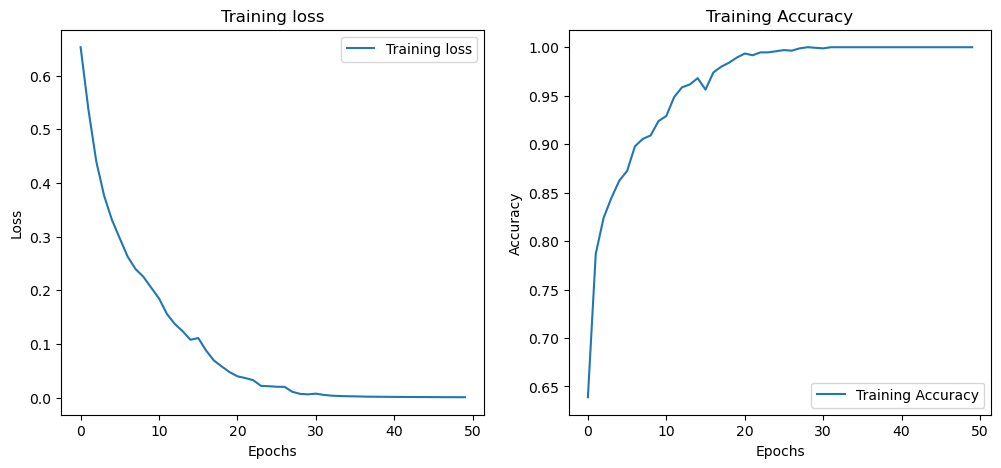

In [51]:
print(f'Train Accuracy: {train_accuracy}, Train Loss: {train_loss}')
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

plot_wo_valid_loss_accuracy(history, input_a, input_b, loss, accuracy)

### with validation data

In [52]:
train_loss, train_accuracy, test_loss, test_accuracy, results_val, history = build_valid_model(scaler_name, epoch, batch_size, X_val_scaled, 
                                                                         Y_val_categorical, X_train_resampled_scaled, Y_train_resampled_categorical, 
                                                                         X_test_scaled, Y_test_categorical)
val_list.append(results_val)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Training Loss: 0.0092, Training Accuracy: 0.9982
Test Loss: 0.8775, Test Accuracy: 0.8623


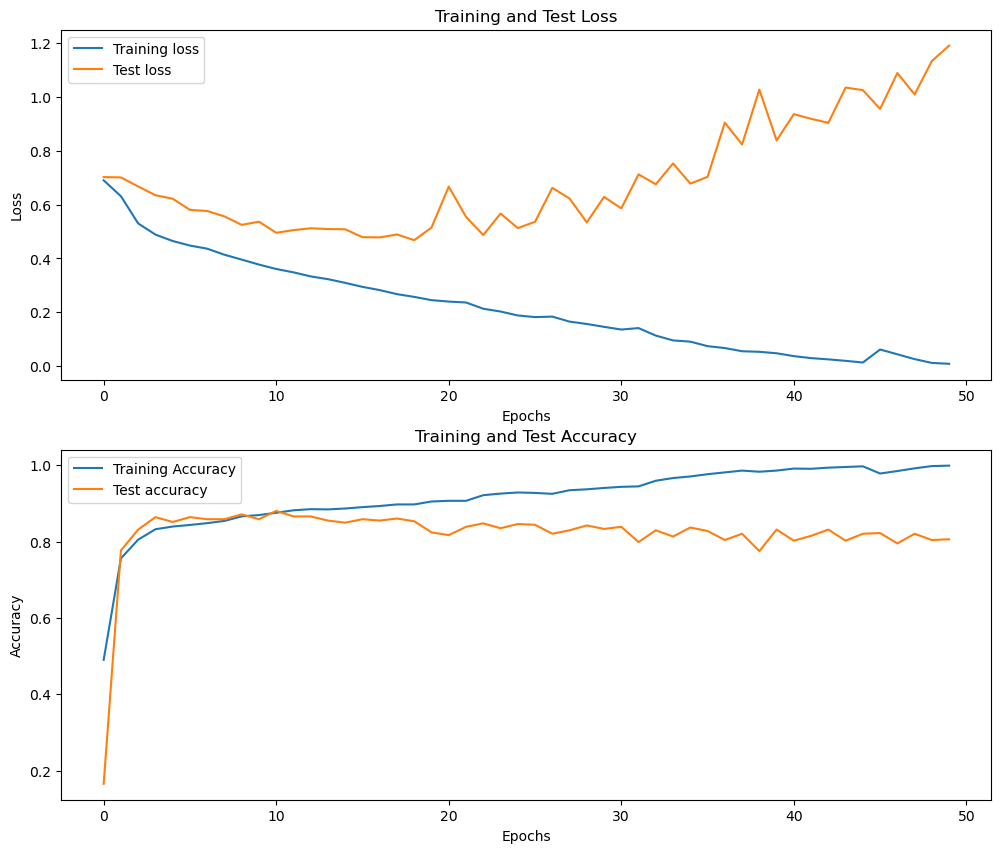

In [53]:
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plot_valid_train(history, input_a, input_2, loss, v_loss, title_1, input_b, input_4, accuracy, v_acc, title_2)

## MinMaxScaler

### without validation data

In [54]:
X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name = pickScaler(MinMaxScaler(), X_train_resampled, X_val, X_test, X_unseen)

epoch = 50
batch_size = 32
train_loss, train_accuracy, test_loss, test_accuracy, results, history = build_wo_valid_model(scaler_name, epoch, batch_size, X_train_resampled_scaled, 
                                                                    Y_train_resampled_categorical, X_test_scaled, Y_test_categorical)
wo_val_list.append(results)

Epoch 1/50


C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


53/53 [==============================] - 2s 2ms/step - loss: 0.6836 - accuracy: 0.6478
Epoch 2/50
53/53 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.7163
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.5461 - accuracy: 0.7760
Epoch 4/50
53/53 [==============================] - 0s 2ms/step - loss: 0.5220 - accuracy: 0.7861
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.5120 - accuracy: 0.7855
Epoch 6/50
53/53 [==============================] - 0s 2ms/step - loss: 0.4987 - accuracy: 0.7843
Epoch 7/50
53/53 [==============================] - 0s 3ms/step - loss: 0.4889 - accuracy: 0.7920
Epoch 8/50
53/53 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.7896
Epoch 9/50
53/53 [==============================] - 0s 2ms/step - loss: 0.4644 - accuracy: 0.8061
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.4578 - accuracy: 0.8085
Epoch 11/50
53/53 [===========

Train Accuracy: 0.8966, Train Loss: 0.283
Test Accuracy: 0.8696, Test Loss: 0.4365


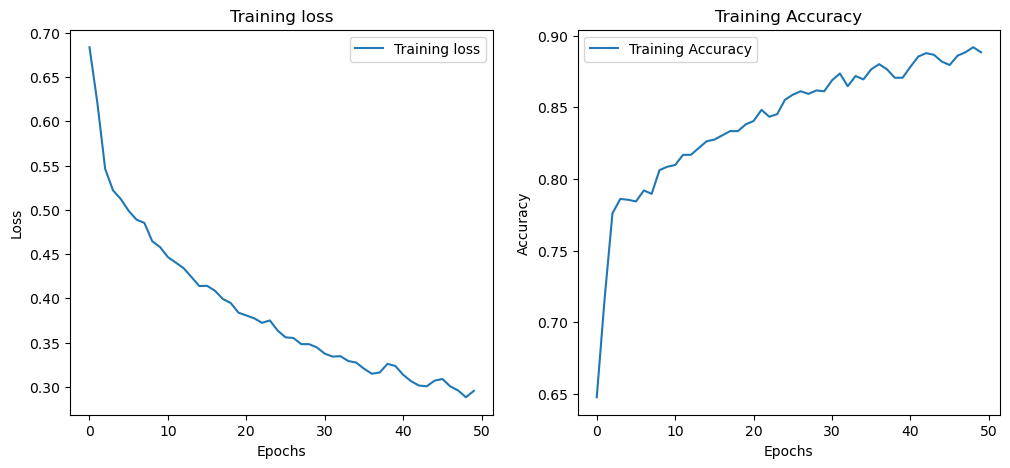

In [55]:
print(f'Train Accuracy: {train_accuracy}, Train Loss: {train_loss}')
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

plot_wo_valid_loss_accuracy(history, input_a, input_b, loss, accuracy)

### with validation data

In [56]:
train_loss, train_accuracy, test_loss, test_accuracy, results_val, history = build_valid_model(scaler_name, epoch, batch_size, X_val_scaled, 
                                                                         Y_val_categorical, X_train_resampled_scaled, Y_train_resampled_categorical, 
                                                                         X_test_scaled, Y_test_categorical)
val_list.append(results_val)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Training Loss: 0.175, Training Accuracy: 0.9539
Test Loss: 0.4284, Test Accuracy: 0.8841


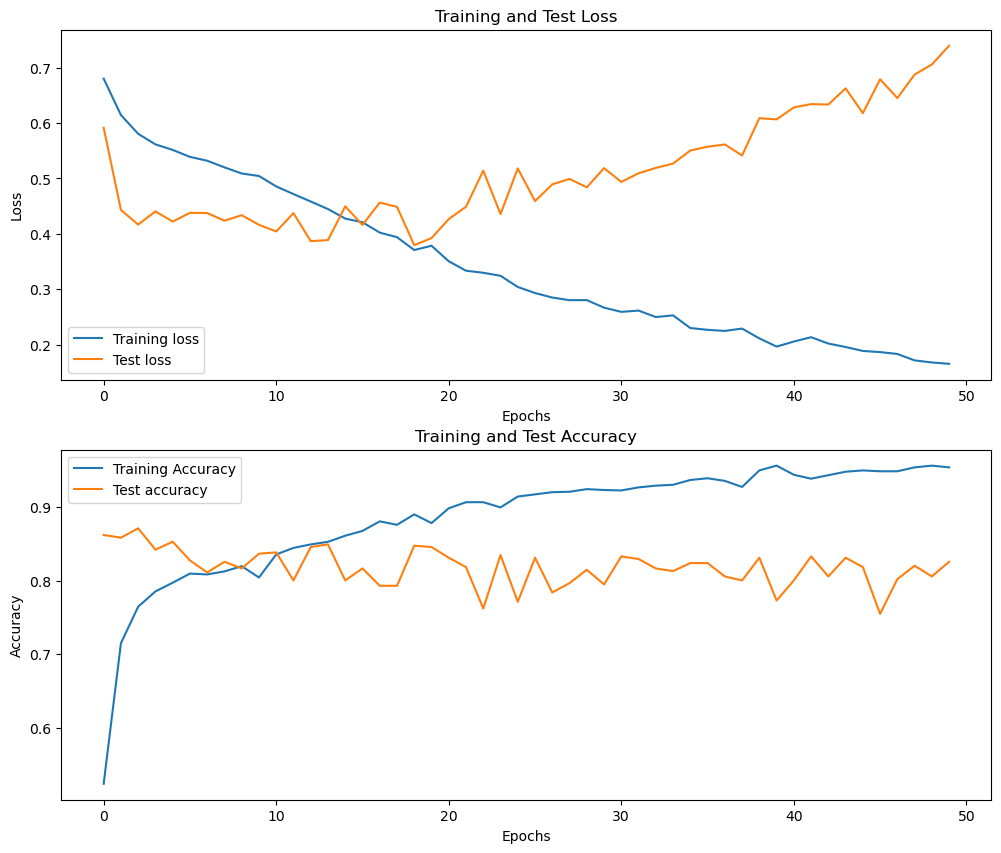

In [57]:
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plot_valid_train(history, input_a, input_2, loss, v_loss, title_1, input_b, input_4, accuracy, v_acc, title_2)

## RobustScaler

### without validation data

In [58]:
X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name = pickScaler(RobustScaler(), X_train_resampled, X_val, X_test, X_unseen)

epoch = 50
batch_size = 32
train_loss, train_accuracy, test_loss, test_accuracy, results, history = build_wo_valid_model(scaler_name, epoch, batch_size, X_train_resampled_scaled, 
                                                                    Y_train_resampled_categorical, X_test_scaled, Y_test_categorical)
wo_val_list.append(results)

Epoch 1/50


C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


53/53 [==============================] - 2s 2ms/step - loss: 0.6557 - accuracy: 0.5981
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.5869 - accuracy: 0.7730
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.5404 - accuracy: 0.8073
Epoch 4/50
53/53 [==============================] - 0s 2ms/step - loss: 0.4707 - accuracy: 0.8162
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3923 - accuracy: 0.8251
Epoch 6/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3643 - accuracy: 0.8375
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3412 - accuracy: 0.8552
Epoch 8/50
53/53 [==============================] - 0s 3ms/step - loss: 0.3252 - accuracy: 0.8593
Epoch 9/50
53/53 [==============================] - 0s 3ms/step - loss: 0.3027 - accuracy: 0.8759
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2871 - accuracy: 0.8818
Epoch 11/50
53/53 [===========

Train Accuracy: 1.0, Train Loss: 0.0012
Test Accuracy: 0.9058, Test Loss: 0.6516


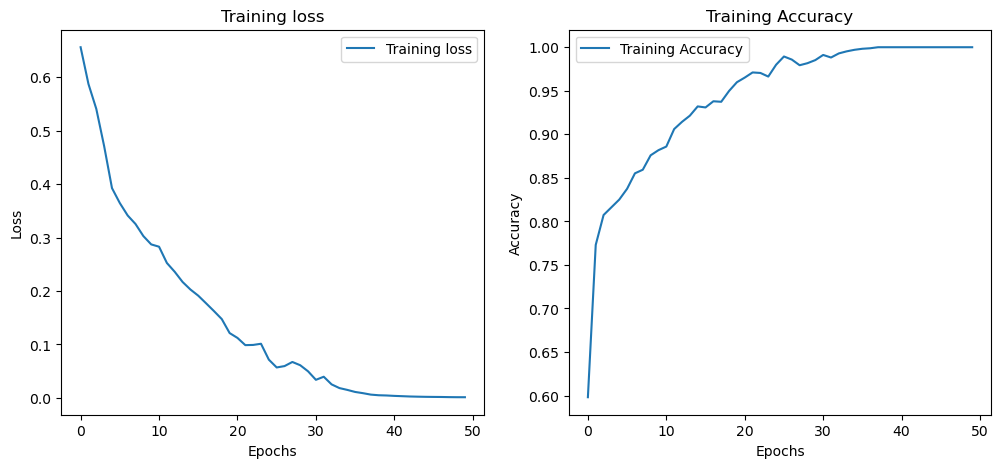

In [59]:
print(f'Train Accuracy: {train_accuracy}, Train Loss: {train_loss}')
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

plot_wo_valid_loss_accuracy(history, input_a, input_b, loss, accuracy)

### with validation data

In [60]:
train_loss, train_accuracy, test_loss, test_accuracy, results_val, history = build_valid_model(scaler_name, epoch, batch_size, X_val_scaled, 
                                                                         Y_val_categorical, X_train_resampled_scaled, Y_train_resampled_categorical, 
                                                                         X_test_scaled, Y_test_categorical)
val_list.append(results_val)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Training Loss: 0.238, Training Accuracy: 0.9173
Test Loss: 0.8183, Test Accuracy: 0.8478


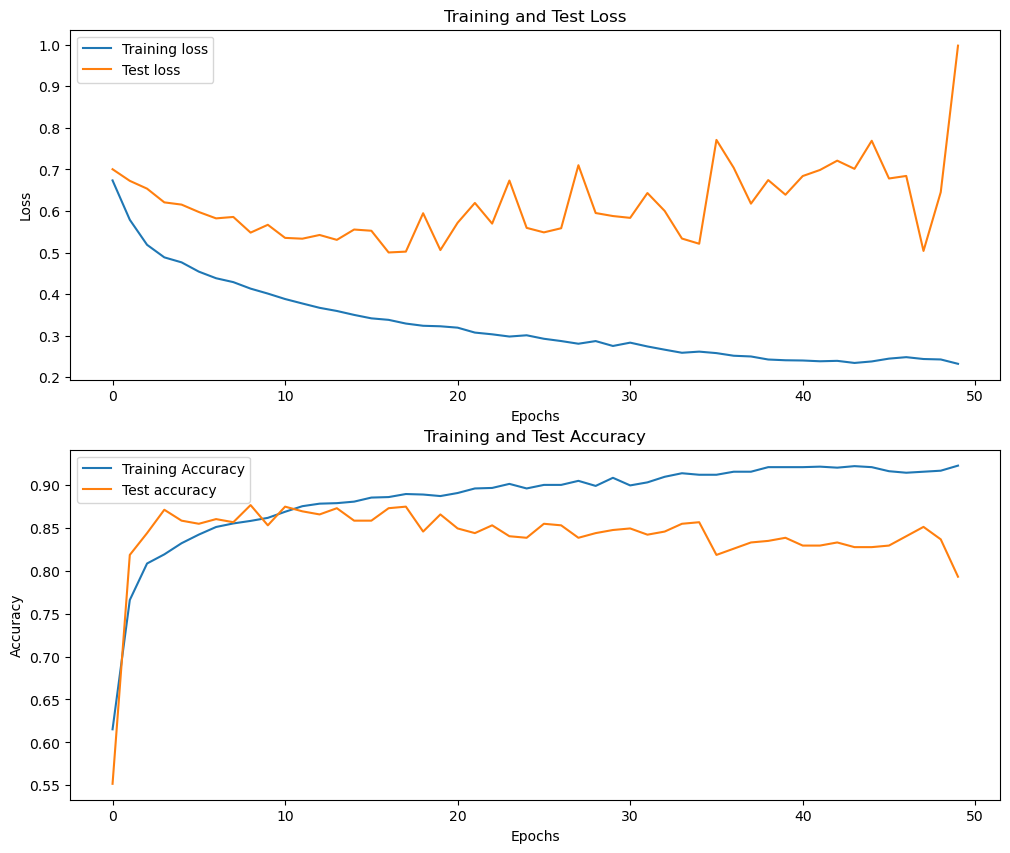

In [61]:
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plot_valid_train(history, input_a, input_2, loss, v_loss, title_1, input_b, input_4, accuracy, v_acc, title_2)

## Overall comparison between different scalers on NN

In [62]:
showNNTablulate("Overall Without Validation Data", wo_val_list, True)
showNNTablulate("Overall With Validation Data", val_list, False)

Overall Without Validation Data
+--------------+----------------+--------------+------------------+-------------+-----------------+
| Model        | Scaler         |   Train loss |   Train accuracy |   Test loss |   Test accuracy |
+==============+================+==============+==================+=============+=================+
| Sequential() | StandardScaler |       0.0006 |           1      |      0.8796 |          0.8913 |
+--------------+----------------+--------------+------------------+-------------+-----------------+
| Sequential() | MinMaxScaler   |       0.283  |           0.8966 |      0.4365 |          0.8696 |
+--------------+----------------+--------------+------------------+-------------+-----------------+
| Sequential() | RobustScaler   |       0.0012 |           1      |      0.6516 |          0.9058 |
+--------------+----------------+--------------+------------------+-------------+-----------------+


Overall With Validation Data
+--------------+----------------+----